## Data Pre-processing

In [2]:
lifeData1 <- read.csv("D:/Code/BIOSTAT682/Life Expectancy Data.csv")
head(lifeData1)

,Country,Year,Status,Life.expectancy,Adult.Mortality,infant.deaths,Alcohol,percentage.expenditure,Hepatitis.B,Measles,⋯,Polio,Total.expenditure,Diphtheria,HIV.AIDS,GDP,Population,thinness..1.19.years,thinness.5.9.years,Income.composition.of.resources,Schooling
,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,2015,Developing,65.0,263,62,0.01,71.279624,65,1154,⋯,6,8.16,65,0.1,584.25921,33736494,17.2,17.3,0.479,10.1
2,Afghanistan,2014,Developing,59.9,271,64,0.01,73.523582,62,492,⋯,58,8.18,62,0.1,612.69651,327582,17.5,17.5,0.476,10.0
3,Afghanistan,2013,Developing,59.9,268,66,0.01,73.219243,64,430,⋯,62,8.13,64,0.1,631.74498,31731688,17.7,17.7,0.470,9.9
4,Afghanistan,2012,Developing,59.5,272,69,0.01,78.184215,67,2787,⋯,67,8.52,67,0.1,669.95900,3696958,17.9,18.0,0.463,9.8
5,Afghanistan,2011,Developing,59.2,275,71,0.01,7.097109,68,3013,⋯,68,7.87,68,0.1,63.53723,2978599,18.2,18.2,0.454,9.5
6,Afghanistan,2010,Developing,58.8,279,74,0.01,79.679367,66,1989,⋯,66,9.20,66,0.1,553.32894,2883167,18.4,18.4,0.448,9.2


In [5]:
library(tidyr)

lifeData <- lifeData1 %>% drop_na()

corrplot 0.92 loaded



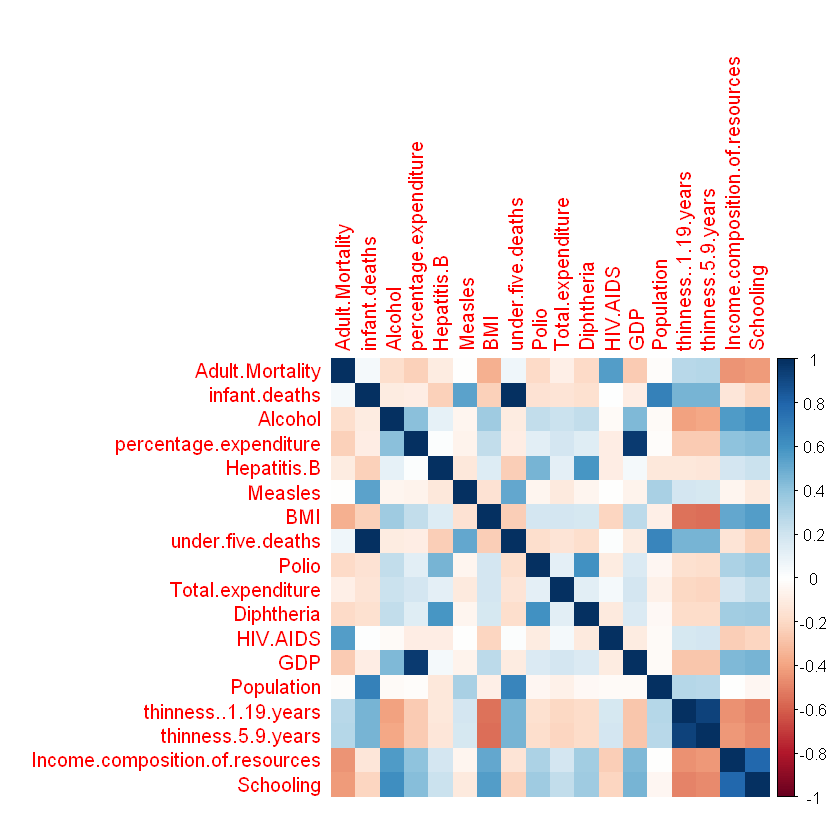

In [9]:
# generate correlation plot

lifeData_Matrix <- as.matrix(lifeData)[,-(1:4)]
lifeData_Matrix.numeric <- apply(lifeData_Matrix, 2, as.numeric)  # element in original matrix is character

library(corrplot)
corrplot(cor(lifeData_Matrix.numeric), method="color")

## Frequentist Way

In [6]:
lmod <- lm(Life.expectancy ~ . - Country, data = lifeData)
summary(lmod)


Call:
lm(formula = Life.expectancy ~ . - Country, data = lifeData)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.7681  -2.1427   0.0273   2.1776  12.4242 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      3.090e+02  4.621e+01   6.687 3.12e-11 ***
Year                            -1.272e-01  2.308e-02  -5.510 4.18e-08 ***
StatusDeveloping                -8.865e-01  3.353e-01  -2.644  0.00827 ** 
Adult.Mortality                 -1.621e-02  9.441e-04 -17.171  < 2e-16 ***
infant.deaths                    8.873e-02  1.059e-02   8.376  < 2e-16 ***
Alcohol                         -1.313e-01  3.366e-02  -3.901 9.95e-05 ***
percentage.expenditure           3.026e-04  1.789e-04   1.691  0.09096 .  
Hepatitis.B                     -3.258e-03  4.449e-03  -0.732  0.46413    
Measles                         -1.033e-05  1.070e-05  -0.966  0.33439    
BMI                              3.183e-02  5.955e-03   5.345 1

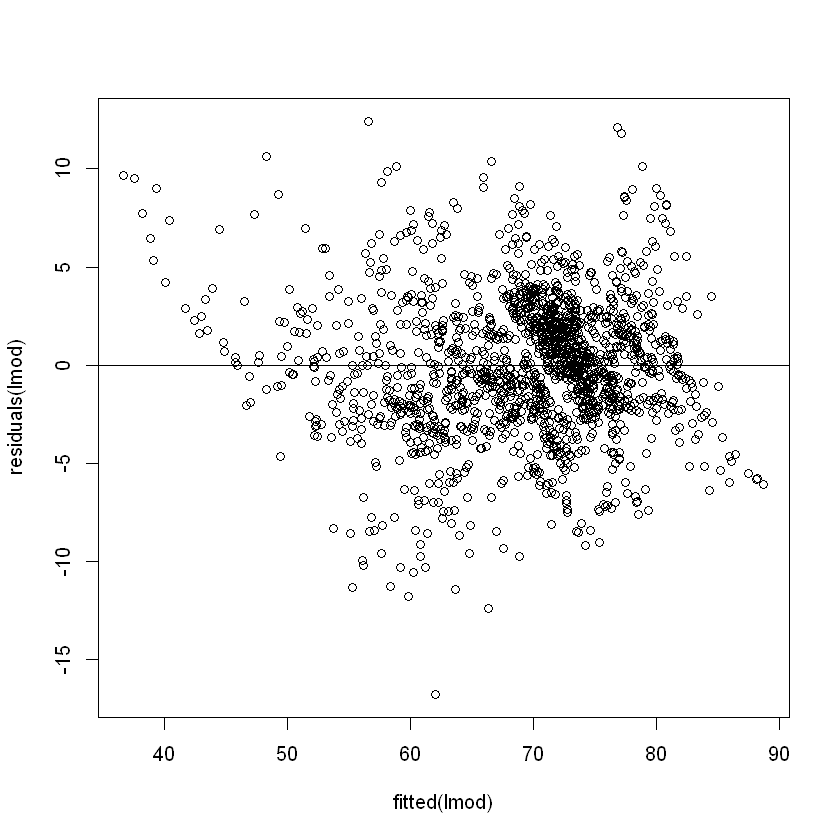

In [7]:
plot(fitted(lmod), residuals(lmod))
abline(h = 0)

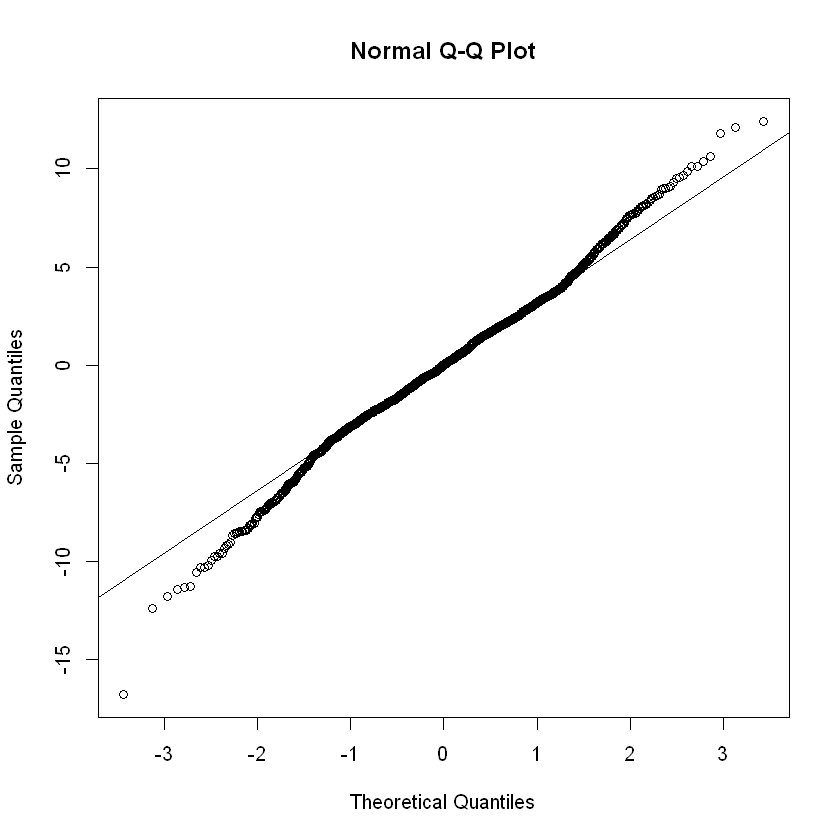

In [8]:
qqnorm(residuals(lmod))
qqline(residuals(lmod))

In [11]:
library(quantreg)
ladmod <- rq(Life.expectancy ~ . - Country, data = lifeData)
summary(ladmod)

Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Warning message in summary.rq(ladmod):
"36 non-positive fis"



Call: rq(formula = Life.expectancy ~ . - Country, data = lifeData)

tau: [1] 0.5

Coefficients:
                                Value     Std. Error t value   Pr(>|t|) 
(Intercept)                     263.27559  35.18477    7.48266   0.00000
Year                             -0.10470   0.01760   -5.94967   0.00000
StatusDeveloping                 -0.01519   0.21259   -0.07143   0.94306
Adult.Mortality                  -0.02168   0.00181  -11.99926   0.00000
infant.deaths                     0.07051   0.01028    6.85988   0.00000
Alcohol                          -0.07762   0.02374   -3.27005   0.00110
percentage.expenditure            0.00013   0.00004    3.07267   0.00216
Hepatitis.B                       0.00202   0.00362    0.55896   0.57627
Measles                           0.00000   0.00001   -0.05876   0.95315
BMI                               0.03075   0.00403    7.62665   0.00000
under.five.deaths                -0.05225   0.00732   -7.14249   0.00000
Polio                      

## Bayesian Way

In [14]:
library(R2jags)

N = nrow(lifeData)
x1 = rep(0,N)
x2 = rep(0,N)
x3 = rep(0,N)
x4 = rep(0,N)
x5 = rep(0,N)
x6 = rep(0,N)
x7 = rep(0,N)
x8 = rep(0,N)
x9 = rep(0,N)
x10 = rep(0,N)
x11 = rep(0,N)
x12 = rep(0,N)
x13 = rep(0,N)
x14 = rep(0,N)
x15 = rep(0,N)
status = rep(0,N)

#set up dummy/index variables
for (i in 1:N) {
  x1[i] = ifelse(lifeData$Year[i] == 2001,1,0)
  x2[i] = ifelse(lifeData$Year[i] == 2002,1,0)
  x3[i] = ifelse(lifeData$Year[i] == 2003,1,0)
  x4[i] = ifelse(lifeData$Year[i] == 2004,1,0)
  x5[i] = ifelse(lifeData$Year[i] == 2005,1,0)
  x6[i] = ifelse(lifeData$Year[i] == 2006,1,0)
  x7[i] = ifelse(lifeData$Year[i] == 2007,1,0)
  x8[i] = ifelse(lifeData$Year[i] == 2008,1,0)
  x9[i] = ifelse(lifeData$Year[i] == 2009,1,0)
  x10[i] = ifelse(lifeData$Year[i] == 2010,1,0)
  x11[i] = ifelse(lifeData$Year[i] == 2011,1,0)
  x12[i] = ifelse(lifeData$Year[i] == 2012,1,0)
  x13[i] = ifelse(lifeData$Year[i] == 2013,1,0)
  x14[i] = ifelse(lifeData$Year[i] == 2014,1,0)
  x15[i] = ifelse(lifeData$Year[i] == 2015,1,0)
  status[i] = ifelse(lifeData$Status[i]=="Developing",1,0)
}

In [22]:
mortality = lifeData$"Adult.Mortality"
infant_deaths = lifeData$"infant.deaths"
alcohol = lifeData$"Alcohol"
percExp = lifeData$"percentage.expenditure"
hepB = lifeData$"Hepatitis.B"
measles = lifeData$"Measles"
BMI = lifeData$"BMI"
under5Deaths = lifeData$"under.five.deaths"
polio = lifeData$"Polio"
totalExp = lifeData$"Total.expenditure"
dipth = lifeData$"Diphtheria"
hivaids = lifeData$"HIV.AIDS"
gdp = lifeData$"GDP"
pop = lifeData$"Population"
thin1019 = lifeData$"thinness..1.19.years"
thin59 = lifeData$"thinness.5.9.years"
incomeComp = lifeData$"Income.composition.of.resources"
school = lifeData$"Schooling"
y = lifeData$"Life.expectancy"
J = length(unique(lifeData$Country)) # number of countries (135)
ident = diag(35)

# encode country
indicesDict = c(unique(lifeData$Country))
indices = rep(0,N)
for (i in 1:N) {
  indices[i] = which(indicesDict==lifeData$Country[i])
}

life_expectancy.data = c("x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11","x12","x13","x14","x15","y","mortality","infant_deaths","alcohol", "status",
                         "percExp","hepB","measles","BMI","under5Deaths","polio","totalExp","dipth","hivaids","gdp","pop","thin1019","thin59",
                         "incomeComp","school","N","J","indices")

In [20]:
save.parms = c("beta","betay","mu")
# use wishart for variance of covariates in the beginning, uninformative prior
life_expectancy.model = function()
{
  for (i in 1:N) {
     y[i] ~ dnorm(mu[indices[i],i],tau)
     # indices[i] gets the cluster number
     # intercept + year_covariates * x0 through x14 + developing_covairate * developing + ...
     mu[indices[i],i] <- 
          betay[indices[i],1] #intercept
          + betay[indices[i],2]*x1[i] #2001
          + betay[indices[i],3]*x2[i] #2002
          + betay[indices[i],4]*x3[i] #2003
          + betay[indices[i],5]*x4[i] #2004
          + betay[indices[i],6]*x5[i] #2005
          + betay[indices[i],7]*x6[i] #2005
          + betay[indices[i],8]*x7[i] #2007
          + betay[indices[i],9]*x8[i] #2008
          + betay[indices[i],10]*x9[i] #2009
          + betay[indices[i],11]*x10[i] #2010
          + betay[indices[i],12]*x11[i] #2011
          + betay[indices[i],13]*x12[i] #2012
          + betay[indices[i],14]*x13[i] #2013
          + betay[indices[i],15]*x14[i] #2014
          + betay[indices[i],16]*x15[i] #2015
          + betay[indices[i],17]*mortality[i] #mortality
          + betay[indices[i],18]*infant_deaths[i] #infant_deaths
          + betay[indices[i],19]*alcohol[i] #alcohol
          + betay[indices[i],20]*percExp[i] #percentage expenditure
          + betay[indices[i],21]*hepB[i] #hepatitis B
          + betay[indices[i],22]*measles[i] #meases
          + betay[indices[i],23]*BMI[i] #BMI 
          + betay[indices[i],24]*under5Deaths[i] #under 5 deaths
          + betay[indices[i],25]*polio[i] #Polio
          + betay[indices[i],26]*totalExp[i] #total expenditure
          + betay[indices[i],27]*dipth[i] #diptheria
          + betay[indices[i],28]*hivaids[i] #hiv.aids
          + betay[indices[i],29]*gdp[i] #gdp
          + betay[indices[i],30]*pop[i] #population
          + betay[indices[i],31]*thin1019[i] #thinness relevance 10-19 yrs old
          + betay[indices[i],32]*thin59[i] #thinness relevance 5-9 yrs old
          + betay[indices[i],33]*incomeComp[i] #income composition
          + betay[indices[i],34]*school[i] #years of schooling
          + betay[indices[i],35]*status[i] #status, developing or not
  }
  for (j in 1:J) {
    for (k in 1:35) {
      betay[j,k] ~ dnorm(beta[k],P)
    }
  }      
  for (k in 1:35) {
    beta[k] ~ dnorm(0,1e-6)
  }
  tau ~ dgamma(1e-6,1e-6)
  P ~ dgamma(1e-6,1e-6)
   
  #P[1:34,1:34] ~ dwish(ident,3)
}

In [23]:
life_expectancy.out = jags(data=life_expectancy.data,parameters.to.save=save.parms,model.file=life_expectancy.model,
                n.chains=3,n.iter=10000,n.burnin=5000,n.thin=1)
print(life_expectancy.out,digits=5)